<a href="https://colab.research.google.com/github/ldaniel-hm/eml_k_bandit/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Luis Daniel Hernández Molinero
    Email: ldaniel@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [ ]:
!git clone https://github.com/josesanchfez-umu/k_brazos_SFDD.git
# Instalar dependencias
!pip install -r ./k_brazos_SFDD/requirementsColab.txt

In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('./src/')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret


['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\python312.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.12_3.12.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml', '', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [3]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                _, stats = arm_stats[idx]
                # Registrar selecciones y recompensas en arm_stats
                stats[chosen_arm][0] += 1  # Contador de selecciones
                stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    for _, stats in arm_stats:
        for arm in stats:
            selections, total_reward = stats[arm]
            stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated


## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [4]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


## Visualización de los resultados

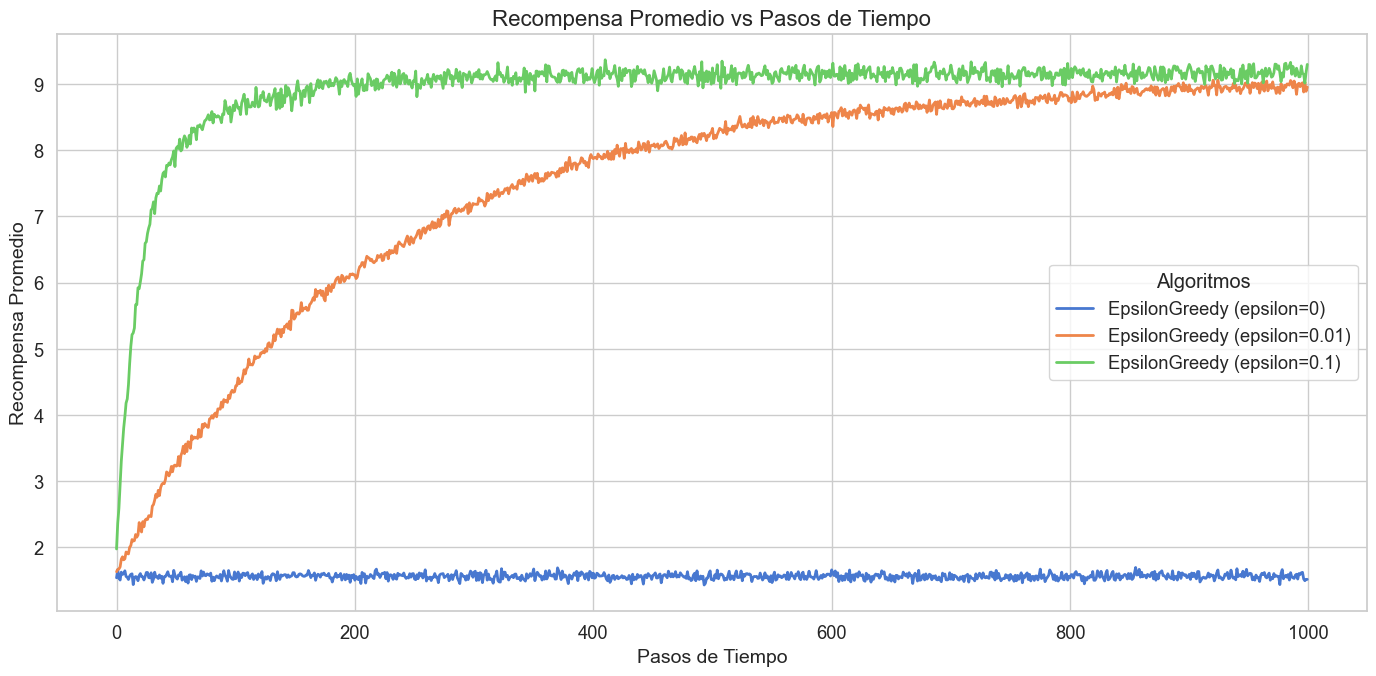

In [5]:
# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)

### Análisis detallado de la imagen

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





### Gráficas de la práctica 1
#### Porcentaje en el que fue seleccionado el grafo óptimo

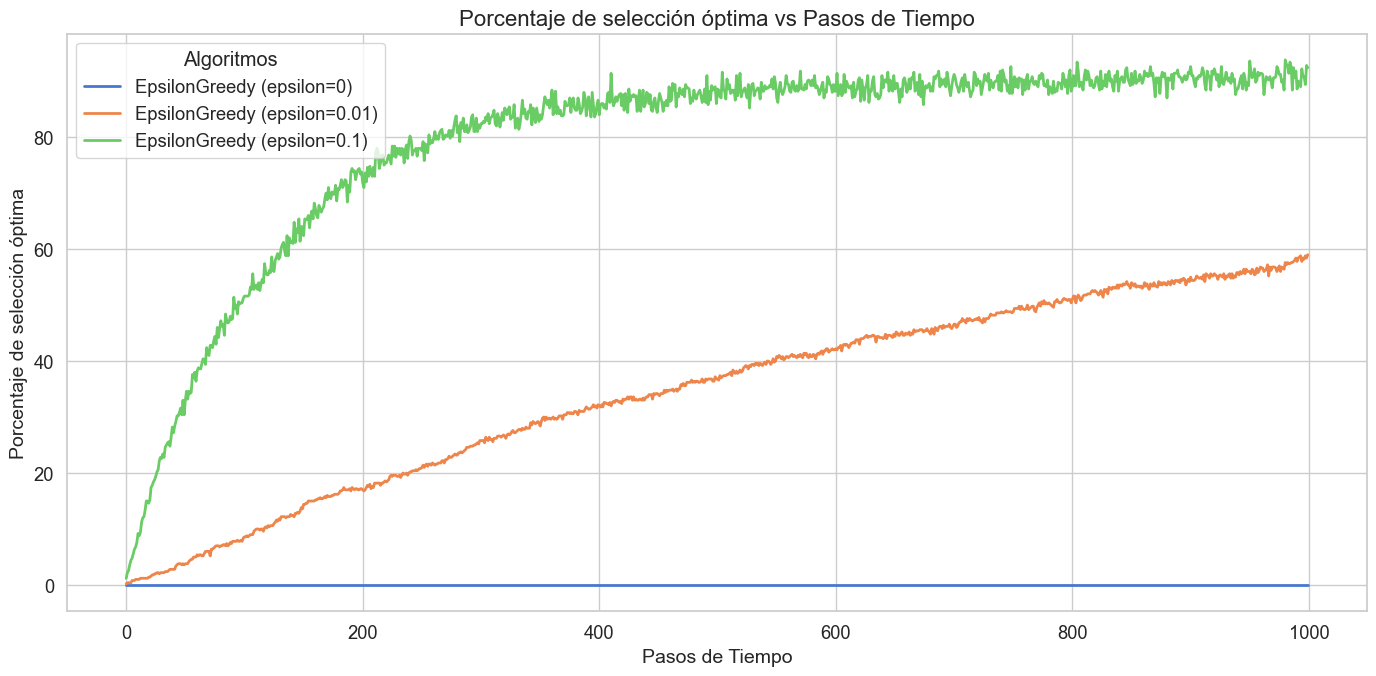

In [6]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Vamos a realizar un pequeño análisis de la gráfica:

- La línea azul (ε = 0): Como ε = 0, el algoritmo siempre sigue una estrategia de explotación, por lo que sólo elige el brazo con la mejor recompensa conocida desde el inicio. En el caso de que el brazo inicial no sea el óptimo, siempre se quedará atrapado eligiendo una mala decisión.
- La línea naranja (ε = 0.01): Como ε ya no tiene un valor nulo, vemos como sigue aún sigue una estrategia que prioriza la explotación, pero con dándole una mínima importancia a la exploración. Eso hace que la eficacia al seleccionar el brazo más óptimo vaya aumentando muy lentamente.
- La línea verde (ε = 0.1): En este caso ya explora un 10% de las veces. Esto produce que al inicio la curva crezca muy rápidamente, acercándose al 80% de acierto al seleccionar el brazo más óptimo, ya que explora al inicio más que los algoritmos anteriores y eso le permite encontrar el brazo óptimo mucho más rápido. También hay que destacar que, aunque sigue explorando el 10% de las veces, la tasa de elección se mantiene alta.

En conclusión, el mejor valor de ε depende del problema, pero en este caso, ε = 0.1 es claramente el mejor.

#### Estadísticas de cada brazo

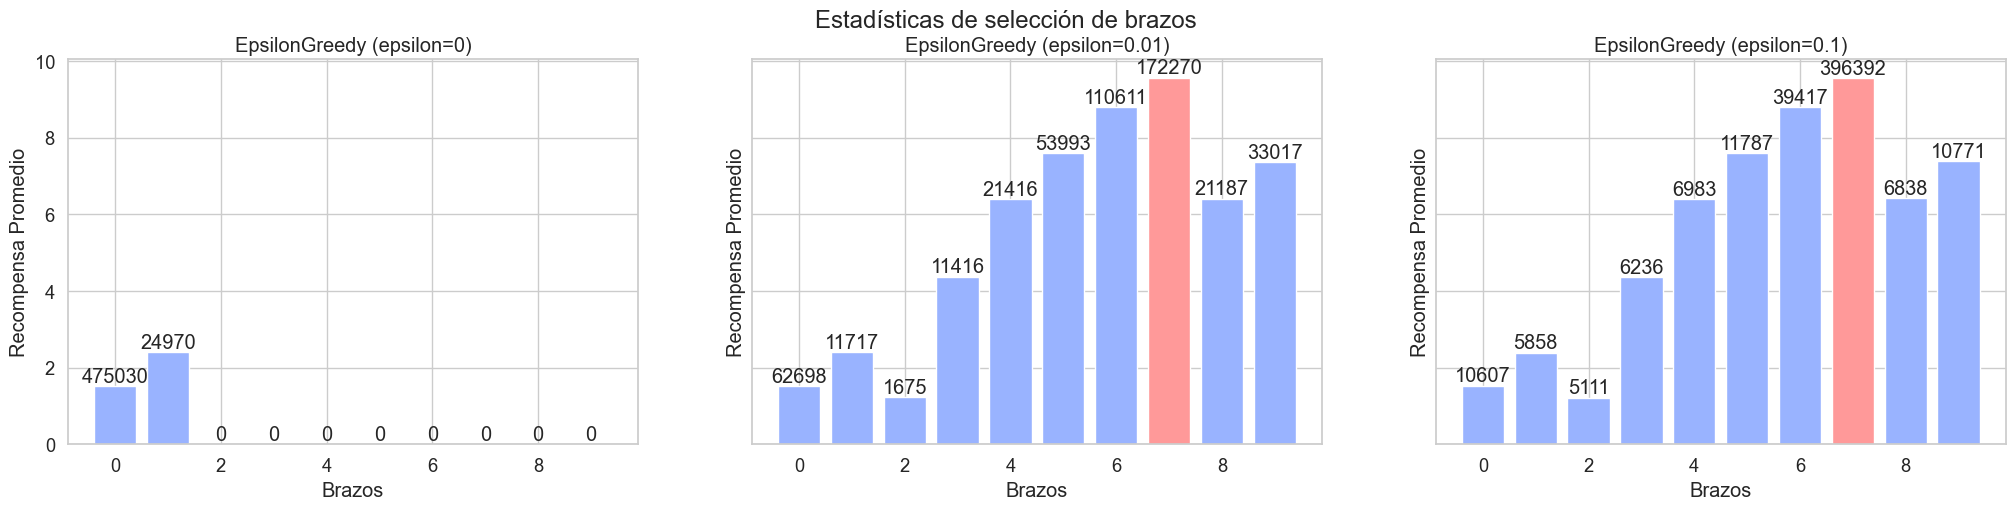

In [9]:
plot_arm_statistics(arm_stats, algorithms, optimal_arm)

Cada gráfico representa los siguientes elementos para cada uno de los tres algoritmos greedy analizados en el experimento previo:
- Cada uno de los brazos disponibles (eje X).
- El número de veces que cada brazo fue seleccionado (etiquetas numéricas sobre las barras).
- La recompensa promedio obtenida de cada brazo (eje Y).
- El brazo óptimo resaltado en rojo (el que tiene la mayor recompensa promedio).


Analizamos brevemente los resultados para las tres gráficas:

**Primera gráfica (ε-greedy = 0)**: Solo explora los dos primeros brazos y nunca prueba otros, lo que sugiere que el algoritmo ha quedado atrapado en una mala decisión temprana y no ha considerado explorar el resto de brazos. Si los primeros brazos no son los mejores, el rendimiento es muy pobre, por no decir pésimo. Sólo se plotean los brazos que han sido elegidos alguna vez, y casi siempre se queda en el primero, que es de los que menos recompensa promedio ofrece.

**Segunda gráfica (ε-greedy = 0.01)**: Se seleccionan todos los brazos en algún momento, a diferencia con el caso greedy puro, observando una tendencia hacia los brazos con recompensas más altas. El brazo óptimo (rojo) consigue, finalmente, ser el más seleccionado, lo que indica que la exploración ha sido suficientemente extensa para aprender completamente cuál es el mejor brazo, pero da cierta posibilidad de mejora, ya que los brazos cercanos son escogidos con bastante frecuencia.

**Tercera gráfica (ε-greedy = 0.1)**: Los resultados son mucho mejores que en el caso de la gráfica anterior, donde vemos una clarísima diferencia entre todos los brazos posibles y el óptimo. Esto quiere decir que este valor de epsilon permite encontrar de forma rápida el brazo óptimo y lo explota, obteniendo una eficiencia mucho mayor respecto al epsilon 0.01.

#### Evolución del rechazo

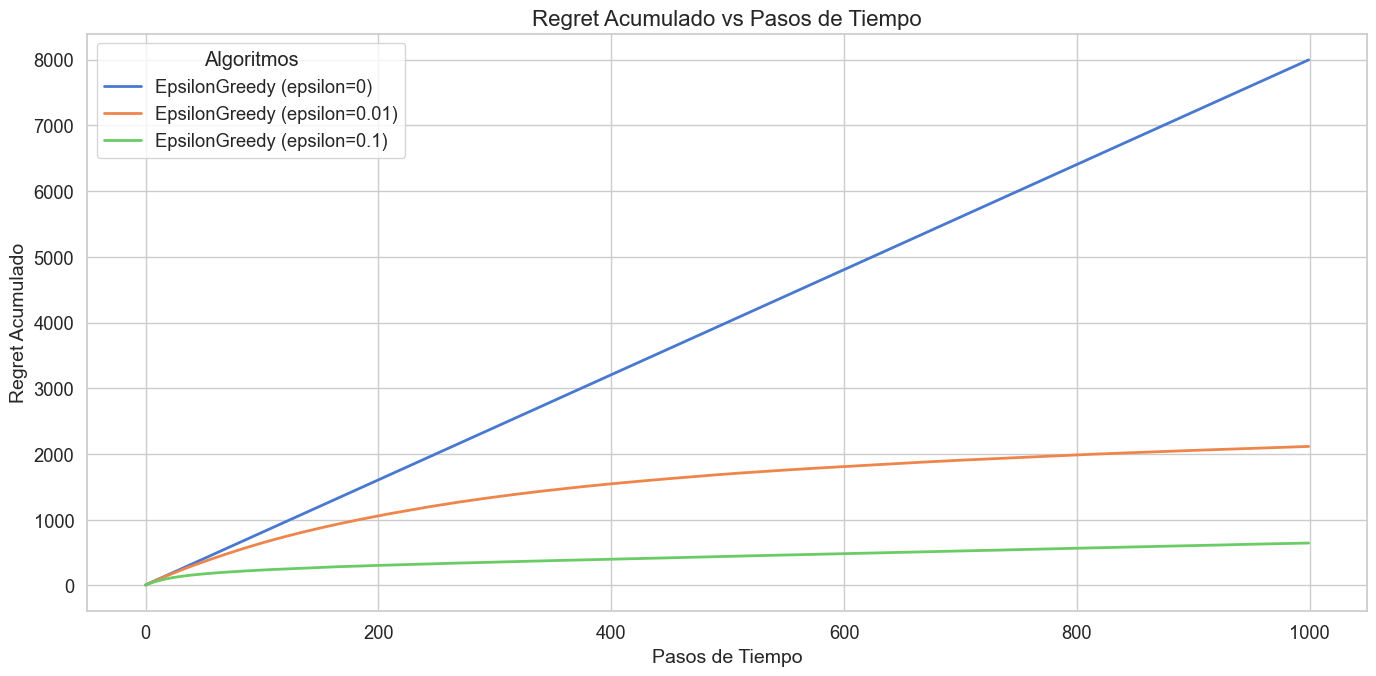

In [8]:
plot_regret(steps, regret_accumulated, algorithms)

El análisis de la gráfica:
- La línea azul (ε = 0): Vemos como el rechazo acumulado va creciendo de forma lineal y constante, ya que nunca explora nuevos brazos y siempre escoge el mismo, por lo que el rechazo obtenido en cada elección también es el mismo.
- La línea naranja (ε = 0.01): Con un factor de exploración casi mínimo, vemos como el rechazo crece más lentamente que en el caso anterior y no es lineal, sino que cada vez es menor, ya que, aunque tarda en hacerlo, eventualmente encuentra el brazo óptimo. 
- La línea verde (ε = 0.1): Es el algoritmo con el rechazo acumulado más bajo, lo que indica que descubre el brazo más óptimo con más rapidez (lo que tiene sentido ya que tiene un factor de exploración mucho más alto). También vemos como empieza a estabilizarse alrededor de los 400 pasos, lo que significa que aprende y deja de explorar tanto cuando ya ha encontrado la mejor opción.

De nuevo, el algoritmo con ε = 0.1 es el mejor en este caso.

#### Discusión sobre la relevancia de las gráficas

En nuestro caso, consideramos que las tres gráficas son relevantes, pero su importancia depende del análisis que se quiera realizar:
- Selección del brazo óptimo: muestra el porcentaje de veces que se elige el brazo óptimo a lo largo del tiempo, e indica qué tan rápido el algoritmo aprende cuál es la mejor opción, por lo tanto, muestra qué tan bien aprende con cada valor de ε.
- Distribución de selecciones: indica cuántas veces es seleccionado un brazo y cuál es su recompensa promedio, entonces permite ver las selecciones que realizan los algoritmos conforme avanza el tiempo. Esta gráfica también ayuda a entener cómo exploran los algoritmos.
- Rechazo acumulado: muestra el rechazo obtenido por el algoritmo al no escoger el brazo más óptimo, lo que nos da una visión general de la eficiencia del aprendizaje llevado a cabo por el algoritmo. 

Si lo que queremos es realizar un análisis general de los algoritmos, consideramos que la gráfica que muestra el porcentaje de la selección óptima es la más importante a la hora de entender el aprendizaje del algoritmo, seguida de la del rechazo acumulado, con el fin de comparar el rendimiento de cada uno.

## Conclusiones

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

El gráfico confirma este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión, **el gráfico muestra cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀